In [155]:
import numpy as np
import pdal
import json
import laspy
import open3d as o3d
import os
import matplotlib.pyplot as plt
import rioxarray as rxa
from os.path import join, basename, exists, dirname, abspath
from glob import glob
import geopandas as gpd
import fiona
from zipfile import ZipFile
import shlex
import subprocess
import py3dep
from shapely.geometry import box
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import contextily as cx

In [156]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [157]:
def cl_call(commamd):
    process = subprocess.Popen(commamd, 
                           stdout=subprocess.PIPE,
                           universal_newlines=True)

    while True:
        output = process.stdout.readline()
        print(output.strip())
        # Do something else
        return_code = process.poll()
        if return_code is not None:
            print('RETURN CODE', return_code)
            # Process has finished, read rest of the output 
            for output in process.stdout.readlines():
                print(output.strip())
            break

In [158]:
test_dir = abspath('../test/09_EXPORT')
laz_fps = glob(join(test_dir,'*.laz'))[:2]
kmz_fp = glob(join(test_dir,'*.kmz'))[0]

In [159]:
with ZipFile(kmz_fp, 'r') as kmz:
    kml_fps = kmz.namelist()
    kmz.extractall(test_dir)
kml_fp = [fp for fp in kml_fps if fp.endswith('kml')][0]
my_map = gpd.read_file(join(test_dir, kml_fp), driver='KML')
my_map[::1000].explore()

In [160]:
import laspy
filepath = "/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/20220215_DryCreek_-_220215_173805_VQ-580.laz"

with laspy.open(filepath) as data:
     hdr = data.header
     crs = hdr.parse_crs()
wgs84 = pyproj.CRS('EPSG:4326')
utm_bounds = box(hdr.mins[0], hdr.mins[1], hdr.maxs[0], hdr.maxs[1])
project = pyproj.Transformer.from_crs(crs, wgs84 , always_xy=True).transform
wgs84_bounds = transform(project, utm_bounds)
dem_wgs = py3dep.get_map('DEM', wgs84_bounds, resolution = 1, crs = 'epsg:4326')
dem_utm = dem_wgs.rio.reproject(crs)
dem_fp = join('/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/dems','full.tif')
dem_utm.rio.to_raster(dem_fp)

In [170]:
# import pickle
# with open('crs.pkl', 'wb') as f:
#     pickle.dump(crs, f)
crs.ellipsoid

ELLIPSOID["WGS84",6378137,298.257223563,
    LENGTHUNIT["metre",1],
    ID["EPSG",7030]]

In [162]:
cmd = 'pdal pipeline -i test.json --readers.las.filename="/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/20220215_DryCreek_-_220215_173805_VQ-580.laz"'
cmd = 'pdal pipeline -i test.json -v 8'
cmd = shlex.split(cmd)
cl_call(cmd)

(PDAL Debug) Debugging...
(pdal pipeline Debug) Executing pipeline in standard mode.
(pdal pipeline filters.dem Debug) GDAL debug: GDAL: GDALOpen(/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/dems/full.tif, this=0x7fcb7039e010) succeeds as GTiff.
(pdal pipeline filters.dem Debug) GDAL debug: GDAL: GDAL_CACHEMAX = 819 MB
(pdal pipeline filters.outlier Debug) 		Labeled 1942608 outliers as noise!
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 1	5540904 ground cells	19695 non-ground cells	(0.35% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 1	5237703 ground cells	322896 non-ground cells	(5.81% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 2	5111576 ground cells	449023 non-ground cells	(8.08% of cells contain ground)
(pdal pipeline filters.smrf Debug) progressiveFilter: radius = 3	5052799 ground cells	507800 non-ground cells	(9.13% of cells contain ground)
(pdal pipeline filt


RETURN CODE 0


GDAL: GDALClose(/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/dems/full.tif, this=0x7fcb7039e010)


### Playing with Tiling in PDAL

In [163]:
out_fns = join(test_dir, 'tiled', basename(laz_fps[0]).replace('.laz','') + '-#.laz')
cmd = shlex.split(f'pdal tile -i {laz_fps[0]} -o {out_fns} --length 1000 -v 8')

os.makedirs(join(test_dir, 'tiled'), exist_ok= True)
cl_call(cmd)
tiled_fps = glob(join(test_dir, 'tiled', '*.laz'))

(PDAL Debug) Debugging...



RETURN CODE 0


(pdal tile Debug) Wrote 1 points to the LAS file
(pdal tile Debug) Wrote 190182 points to the LAS file
(pdal tile Debug) Wrote 1510930 points to the LAS file
(pdal tile Debug) Wrote 942580 points to the LAS file
(pdal tile Debug) Wrote 818487 points to the LAS file
(pdal tile Debug) Wrote 1147245 points to the LAS file
(pdal tile Debug) Wrote 6 points to the LAS file
(pdal tile Debug) Wrote 12207258 points to the LAS file
(pdal tile Debug) Wrote 10391384 points to the LAS file
(pdal tile Debug) Wrote 7765417 points to the LAS file
(pdal tile Debug) Wrote 9893842 points to the LAS file
(pdal tile Debug) Wrote 9598439 points to the LAS file
(pdal tile Debug) Wrote 3753245 points to the LAS file


## Visualization

In [164]:
PC = laspy.read('/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/crop.laz')

points = np.vstack((PC.X, PC.Y, PC.Z)).transpose()

cloud = o3d.geometry.PointCloud()
cloud.points = o3d.utility.Vector3dVector(points)
#pcd.colors = o3d.utility.Vector3dVector(colors/65535)
#pcd.normals = o3d.utility.Vector3dVector(normals)0
o3d.visualization.draw_geometries([cloud])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/crop.laz'

In [ ]:
PC = laspy.read('/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/tiled/20220215_DryCreek_-_220215_180952_VQ-580--1_2.laz')

points = np.vstack((PC.X, PC.Y, PC.Z)).transpose()
points.size

4532790

In [ ]:
PC = laspy.read('/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/filter_test.laz')

points = np.vstack((PC.X, PC.Y, PC.Z)).transpose()
points.size

4434651

In [ ]:
out = rxa.open_rasterio('/Users/zachkeskinen/Documents/helicopter-lidar-processing/test/09_EXPORT/filter_class_full.tif', mask_and_scale=True)

INFO - 2022-07-17 12:24:53,235 - io - GDAL signalled an error: err_no=4, msg="`/vsimem/ccb3c464-b378-4462-98c8-6b63a085a61a/ccb3c464-b378-4462-98c8-6b63a085a61a.tif' not recognized as a supported file format."


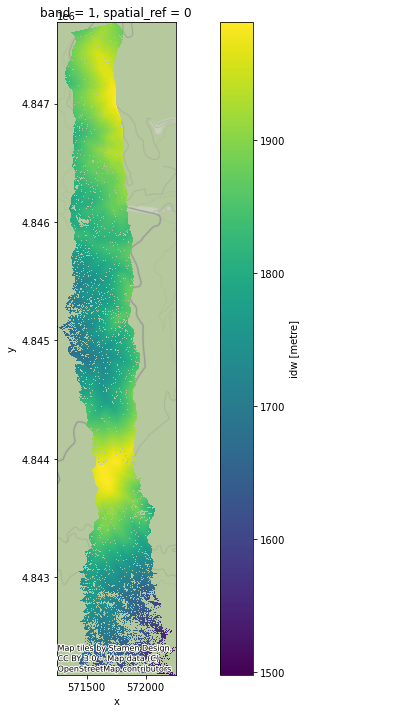

In [ ]:
f, ax = plt.subplots(figsize = (16,12))
out.plot(ax = ax)
cx.add_basemap(ax= ax, crs = crs)

In [ ]:
dem_utm.res

AttributeError: 'DataArray' object has no attribute 'res'

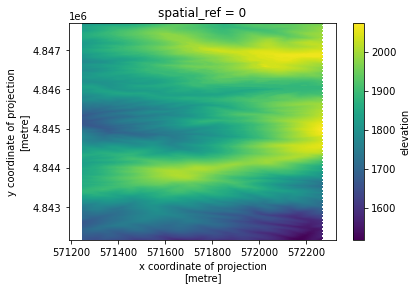

In [ ]:
dem_utm.plot()